In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from util import read_plumed_file
# plot clustering stuff
import itertools
from scipy import linalg
import matplotlib as mpl
# sklearn PCA and GMM stuff
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MeanShift
from sklearn.mixture import GaussianMixture

In [2]:
def pca_transform(df_list, cvs, start_time=100000, end_time=250000, return_pca=False):
    ref = pd.concat(
        [df.loc[start_time:end_time, cvs] for df in df_list],
        ignore_index=True
    )

    scaler = StandardScaler()
    scaler.fit(ref.values)
    X = scaler.transform(ref.values)

    pca = PCA(n_components=2)
    pca.fit(X)

    print(f'frxn variance explained: {pca.explained_variance_ratio_}')
    print(f'singular values: {pca.singular_values_}')
    if return_pca:
        return pca.transform(X), pca, scaler
    return pca.transform(X)


def plot_results(X, Y_, colors, title, centers=None, savefile=None, show_pdb=False):
    plt.figure(figsize=(5, 5))
    for i, color in enumerate(colors):
        if not np.any(Y_ == i):
            continue
        ax1 = plt.subplot(1, 1, 1)
        ax1.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .2, color=colors[i], alpha=0.1, zorder=0)
        if centers is not None:
            ax1.scatter(centers[i][0], centers[i][1], color="#373737", marker="x", zorder=1)
        #ax2 = plt.subplot(1, 2, 2)
        #ax2.scatter(X[Y_ == i, 1], X[Y_ == i, 2], .2, color=colors[i], alpha=0.05)
    
    if show_pdb:
        plt.scatter([-0.6502688], [-0.13362931], color="#373737", marker="*", zorder=1)    
        
    #plt.xticks(())
    #plt.yticks(())
    plt.title(title)
    if savefile is not None:
        plt.savefig(savefile, bbox_inches='tight', dpi=300)
    

def plot_cluster_averages(
    clust_frames, 
    colors, 
    figsize=(9, 3), 
    savefile=None,
):
    # concat all frames to recreate overall mean reference
    ref = pd.concat(clust_frames, ignore_index=True)

    # plot with error bars
    fig = plt.figure(figsize=figsize)

    for idx, clust_df in enumerate(clust_frames):
        # plot just the 1st 2 lusters so the difference is more obvious
        ax = plt.subplot(len(clust_frames), 1, idx + 1)
        ax.plot([-1, len(ref.columns) + 1], [0, 0], c='k', ls='--', alpha=0.3)
        ax.errorbar(
            range(len(clust_df.mean().values)), 
            clust_df.mean().values - ref.mean().values, 
            yerr=clust_df.std().values,
            fmt='o',
            #alpha=0.5,
            color=colors[idx],
            label=f'clust {idx}'
        )
        
        plt.xticks(
            ticks=[idx for idx, val in enumerate(ref.columns)], 
            labels=[cv[:6] for cv in ref.columns], 
            rotation=45
        )
        plt.xlim(-1, len(ref.columns) + 0.5)
        plt.ylim(-0.45, 0.45)
        #ax.yaxis.tick_right()
        #ax.legend(loc=0)
        
    if savefile is not None:
        plt.savefig(savefile, bbox_inches='tight', dpi=300)

In [3]:
def plot_clust_vs_time(
    df_list, 
    clusters, 
    colors,
    cv='R406_com_dist', 
    start_time=50, 
    end_time=250, 
    plot_stride=50,
    ylim=None,
    savefile=None,
):
    start_time = start_time * 1000  # convert to ps
    end_time = end_time * 1000  # convert to ps
    # get trajectory len in terms of number of frames
    n_frames = df_list[0].loc[start_time:, :].shape[0]
    
    
    means = [df.loc[start_time::plot_stride, cv].mean() for df in df_list]
    cv_mean = np.array(means).mean()
    
    plt.figure(figsize=(len(df_list) * 5,2))
    for idx, df in enumerate(df_list):
        df.loc[start_time:, 'cluster'] = (
            clusters[idx * n_frames:(idx + 1) * n_frames]
        )

        ax = plt.subplot(1, len(df_list), idx + 1)
        ax.scatter(
            df.index[int(start_time/2)::plot_stride] / 1000, 
            df.loc[start_time::plot_stride, cv],
            c=np.take(colors, [int(i) for i in df.loc[start_time::plot_stride, 'cluster'].values])
        )
        ax.plot([start_time / 1000, end_time / 1000], [cv_mean, cv_mean], ls='--', color='k', alpha=0.5)
        plt.ylim(ylim)
        plt.xlim((start_time / 1000, end_time / 1000))
    
    if savefile is not None:
        plt.savefig(f'{savefile}_{cv}.png', bbox_inches='tight', dpi=300)
    plt.show()

In [4]:
from sklearn.metrics import silhouette_score

def cluster_score(X, bw, stride=20):
    X = X[::stride, :]
    
    clusterer = MeanShift(
        bandwidth=bw, 
        bin_seeding=True, 
        min_bin_freq=5,
        n_jobs=-1,
    )
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f'bw: {bw}, score = {silhouette_avg:0.2}')
    return

In [5]:
def get_central_frame(transformed, clusterer, df_list, start_time=50000, end_time=250000, stride=1):

    for idx, center in enumerate(clusterer.cluster_centers_):
        # get frame with PCs closest to center
        central_frame = np.argmin(np.square(transformed - center).sum(axis=1))
        
        # get time index for appropriate simulation
        if central_frame < len(df_list[0].loc[start_time:end_time:stride, :].index):
            time = df_list[0].loc[start_time:end_time:stride, :].index[central_frame]
            print(f'clust {idx + 1} representative time: simulation 1, {time}')
        elif central_frame < 2 * len(df_list[0].loc[start_time:end_time:stride, :].index):
            time = df_list[1].loc[start_time:end_time:stride, :].index[central_frame - len(df_list[0].loc[start_time:end_time:stride, :].index)]
            print(f'clust {idx + 1} representative time: simulation 2, {time}')
        elif central_frame < 3 * len(df_list[0].loc[start_time:end_time:stride, :].index):
            time = df_list[2].loc[start_time:end_time:stride, :].index[central_frame - 3 * len(df_list[0].loc[start_time:end_time:stride, :].index)]
            print(f'clust {idx + 1} representative time: simulation 3, {time}')

# indoxyl sulfate

In [8]:
iso1 = read_plumed_file('data/indoxyl-sulfate/driver/COLVAR.1')
iso2 = read_plumed_file('data/indoxyl-sulfate/driver/COLVAR.2')
iso3 = read_plumed_file('data/indoxyl-sulfate/driver/COLVAR.3')

cvs_of_interest = [
    'L383_com_dist', 'N387_com_dist', 'R406_com_dist', 
    'Y407_com_dist', 'K410_com_dist', 'L426_com_dist', 
    'V429_com_dist', 'L449_com_dist', 'S485_com_dist',
]

iso = pd.concat(
        [df.loc[50000:250000, cvs_of_interest] for df in [iso1, iso2, iso3]],
        ignore_index=True
)

# do PCA and transform with CVs of interest
transformed, pca, scaler = pca_transform(
    [iso1, iso2, iso3], 
    cvs_of_interest, 
    start_time=50000, 
    end_time=250000, 
    return_pca=True,
)

for idx, pc in enumerate(pca.components_):
    print()
    print(f'PC{idx}: {pc}')

frxn variance explained: [0.57273883 0.14825248]
singular values: [1243.54746481  632.68135618]

PC0: [ 0.02731892  0.36729435 -0.28211098 -0.29569384 -0.40287552  0.3823934
  0.41292922  0.32708666 -0.33361274]

PC1: [ 0.67075389  0.19714505 -0.40387402 -0.31611159  0.10997153 -0.01731968
 -0.05375021 -0.31538324  0.36528468]


In [9]:
bandwidths = np.linspace(0.5, 2.5, 21)
silhouette_scores = np.zeros_like(bandwidths)
for bw in bandwidths:
    silhouette_scores = cluster_score(transformed, bw)

bw: 0.5, score = 0.2
bw: 0.6, score = 0.32
bw: 0.7, score = 0.57
bw: 0.8, score = 0.58
bw: 0.9, score = 0.61
bw: 1.0, score = 0.6
bw: 1.1, score = 0.64
bw: 1.2000000000000002, score = 0.64
bw: 1.3, score = 0.64
bw: 1.4, score = 0.64
bw: 1.5, score = 0.64
bw: 1.6, score = 0.64
bw: 1.7000000000000002, score = 0.64
bw: 1.8, score = 0.64
bw: 1.9000000000000001, score = 0.64
bw: 2.0, score = 0.64
bw: 2.1, score = 0.64
bw: 2.2, score = 0.64
bw: 2.3, score = 0.64
bw: 2.4000000000000004, score = 0.64
bw: 2.5, score = 0.64


# select appropriate number of clusters based on mean silhouette score

For n_clusters = 2 The average silhouette_score is : 0.6434228425901255
For n_clusters = 3 The average silhouette_score is : 0.3762974094509556
For n_clusters = 4 The average silhouette_score is : 0.41241687773362


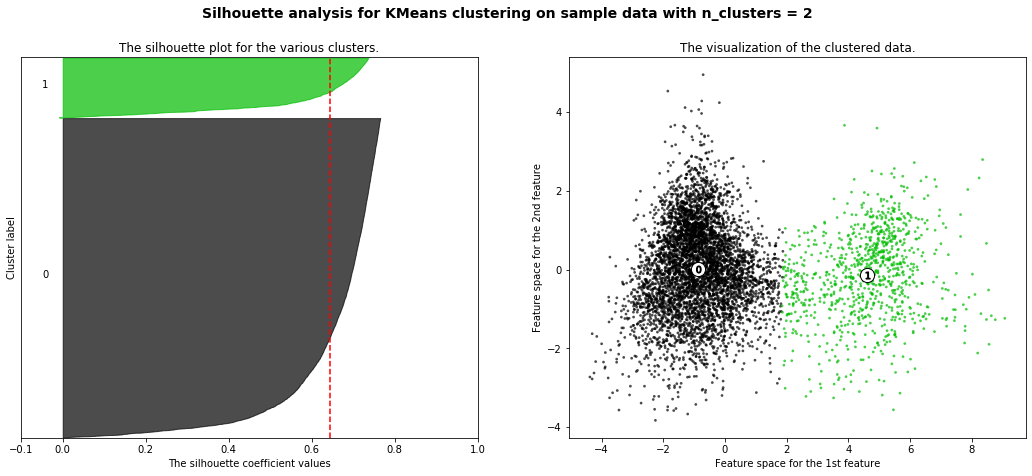

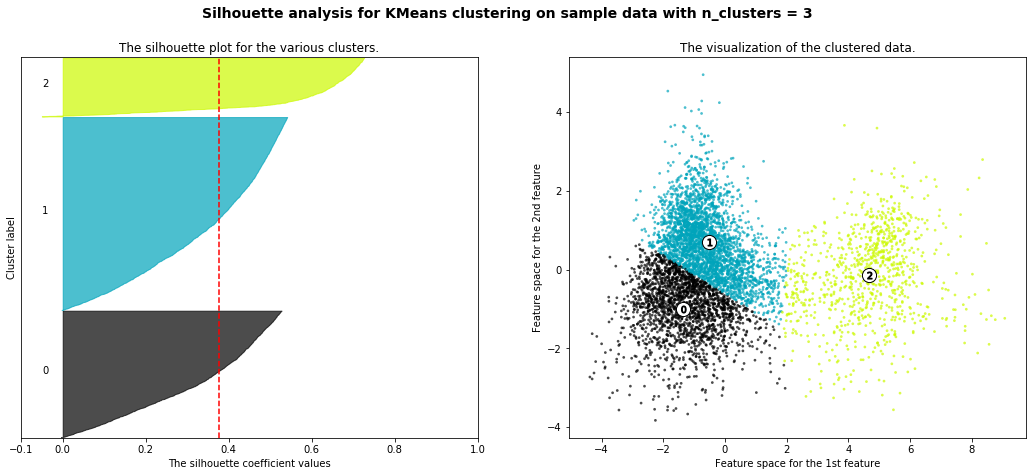

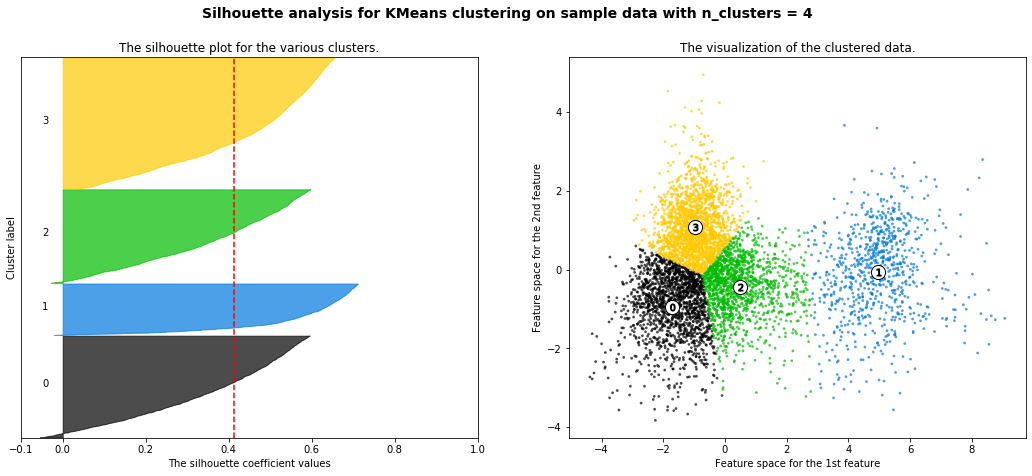

In [10]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

X = transformed[::50, :]

range_n_clusters = [2, 3, 4]

clusterer = MeanShift(
    bandwidth=1.0, 
    bin_seeding=True, 
    min_bin_freq=50,
    n_jobs=-1,
).fit(transformed)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    # ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)  #, n_jobs=-1)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.savefig(f'iso_silhoutte_{n_clusters}.png', bbox_inches='tight', dpi=300)

# create plots with appropriate number of clusters

In [12]:
n_clusts = 2

#clusterer = KMeans(n_clusters=n_clusts, random_state=10).fit(transformed)
#clusterer = GaussianMixture(n_components=n_clusts, tol=1e-9).fit(transformed)
clusterer = MeanShift(
    bandwidth=1.1, 
    bin_seeding=True, 
    min_bin_freq=50,
    n_jobs=-1,
).fit(transformed)

/Users/joshsmith/anaconda3/envs/uremic_toxins/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


clust0 - center = [-0.95090171  0.49595494];  weight = 0.8470781958847078

clust1 - center = [4.96246285 0.44758719];  weight = 0.1529218041152922



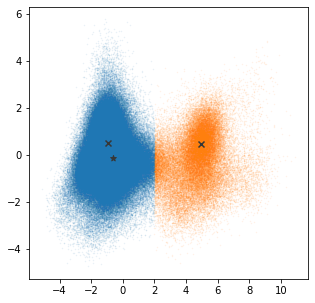

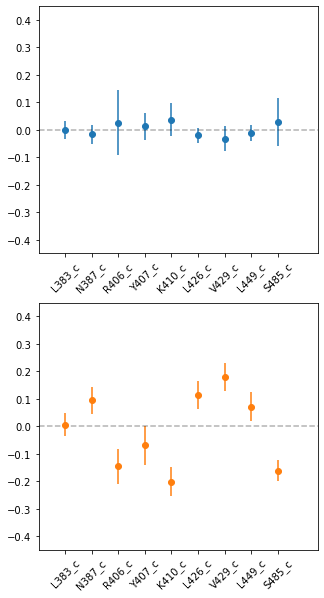

In [13]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

# plot clustering results
plot_results(
    transformed, 
    clusterer.predict(transformed), 
    colors,
    None,
    clusterer.cluster_centers_,
    #clusterer.means_,
    savefile='iso_clustering_results.png',
    show_pdb=True
)

# plot CV averages for each cluster
clusters = clusterer.predict(transformed)

# get subset of dataframe for 
clust_frames = [
    iso.iloc[np.where(clusters == x)] for x in np.unique(clusters)
]

plot_cluster_averages(
    clust_frames, colors=colors, figsize=(5, 5 * n_clusts), savefile='iso_clust_props.png'
)


for idx, df in enumerate(clust_frames):
    weight = df.shape[0] / iso.shape[0]
    center = clusterer.cluster_centers_[idx]
    #center = clusterer.means_[idx]
    print(f'clust{idx} - center = {center};  weight = {weight}')
    print()

In [14]:
get_central_frame(transformed, clusterer, [iso1, iso2, iso3])

clust 1 representative time: simulation 1, 210678.0
clust 2 representative time: simulation 3, 115290.0


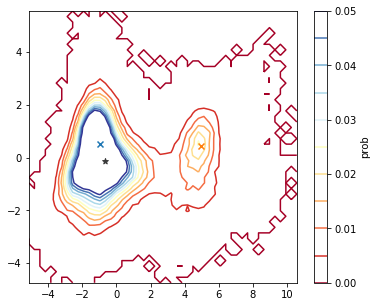

In [15]:
cm = plt.cm.get_cmap('RdYlBu')

hist, x_edges, y_edges = np.histogram2d(
    transformed[:, 0], transformed[:, 1], bins=50, density=True,
)

hist = hist.T

plt.figure(figsize=(6, 5))
plt.contour(
    x_edges[:-1], 
    y_edges[:-1], 
    hist, 
    levels=np.linspace(0.0, 0.05, 11),
    cmap=cm,
    zorder=0,
)
    
cbar = plt.colorbar()
#plt.clim(0, energy_cut)
#plt.set_cmap('viridis')
cbar.ax.set_ylabel('prob')

for idx, center in enumerate(clusterer.cluster_centers_):
    # plot cluster center over pdf contour
    plt.scatter(center[0], center[1], color=colors[idx], marker="x", zorder=1)
    # calculate and plot average over pdf contour
    #avg = pca.transform(scaler.transform(clust_frames[idx].mean().values.reshape(1, -1)))[0]
#     mode = stats.mode(np.round(pca.transform(scaler.transform(clust_frames[idx].values)), decimals=2)).mode[0]
#     plt.scatter(avg[0], avg[1], color="#373737", marker="+", zorder=2)
#     plt.scatter(mode[0], mode[1], color="#555555", marker="+", zorder=3)
plt.scatter([-0.6502688], [-0.13362931], color="#373737", marker="*", zorder=1)
plt.savefig('iso_pca.png', bbox_inches='tight', dpi=300)

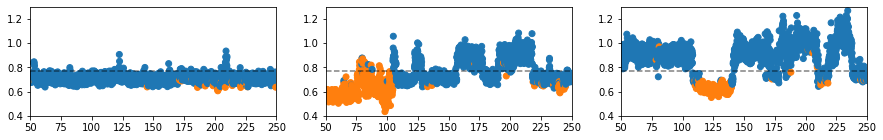

In [16]:
plot_clust_vs_time(
    [iso1, iso2, iso3], 
    clusters, 
    colors, 
    cv='R406_com_dist', 
    start_time=50,
    end_time=250,
    plot_stride=50,
    ylim=(0.4, 1.3),
    savefile='iso'
)

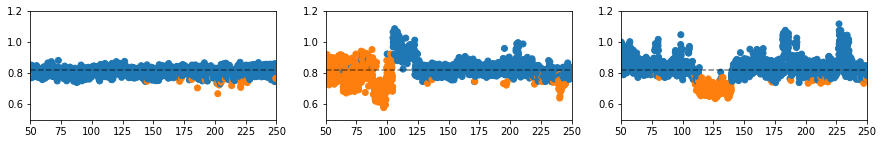

In [17]:
plot_clust_vs_time(
    [iso1, iso2, iso3], 
    clusters, 
    colors, 
    cv='Y407_com_dist', 
    start_time=50,
    end_time=250,
    plot_stride=50,
    ylim=(0.5, 1.2),
    savefile='iso'
)

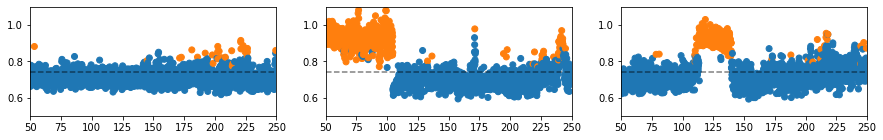

In [18]:
plot_clust_vs_time(
    [iso1, iso2, iso3], 
    clusters, 
    colors, 
    cv='V429_com_dist', 
    start_time=50,
    end_time=250,
    plot_stride=50,
    ylim=(0.5, 1.1),
    savefile='iso'
)